In [28]:
import pandas as pd
import numpy as np

In [29]:
#IMPORT DATASET
dataset_dir = "dataset/ISEAR.csv"
df = pd.read_csv(dataset_dir, encoding='latin-1')

# df = pd.read_csv('dataset/train.txt', header =None, sep =';', names = ['Text','Emotion'], encoding='utf-8')


# import pandas as pd
# with open('./out_train/dial.txt', encoding='utf-8') as f:
#     data = f.readlines();

# df1 = pd.DataFrame(data, columns=['Text'])

# with open('./out_train/emo.txt', encoding='utf-8') as f:
#     data = f.readlines();

# df = pd.concat([df1, pd.DataFrame(data, columns=['Emotion'])], axis=1)
# df = df.drop_duplicates()

# emotion_map = {'0\n': 'no emotion', '1\n': 'anger', '2\n': 'disgust', '3\n': 'fear', '4\n': 'happiness', '5\n': 'sadness', '6\n': 'surprise'}

# df['Emotion'] = df['Emotion'].map(emotion_map)

# df = df[df['Emotion'] != 'no emotion']

In [30]:
#CONSTANTS
max_embedding_length = 300 #MAX EMBEDDING DIMENSION
max_sequence_length = 400 #INPUT LENGTH

In [31]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [32]:
# Remove numbers
df['Text'] = df['Text'].apply(lambda x: re.sub('[0-9]+', '', x))

# Remove punctuations
df['Text'] = df['Text'].apply(lambda x: re.sub('[^\w\s]+', '', x))

# Convert to lowercase
df['Text'] = df['Text'].apply(lambda x: x.lower())

# Remove stop words
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in stop_words]))

# Tokenize
df['Tokenized'] = df['Text'].apply(lambda x: nltk.word_tokenize(x))

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()

    lemmatized = [lemmatizer.lemmatize(token) for token in text]
    return lemmatized

df['Lemmatized'] = df['Tokenized'].apply(lemmatize)


detokenizer = TreebankWordDetokenizer()

df['Detokenized'] = df['Lemmatized'].apply(lambda x: detokenizer.detokenize(x))

In [33]:
df 

,Emotion,Text,Tokenized,Lemmatized,Detokenized
0,joy,period falling love time met especially met lo...,"[period, falling, love, time, met, especially,...","[period, falling, love, time, met, especially,...",period falling love time met especially met lo...
1,fear,involved traffic accident,"[involved, traffic, accident]","[involved, traffic, accident]",involved traffic accident
2,anger,driving home several days hard work motorist a...,"[driving, home, several, days, hard, work, mot...","[driving, home, several, day, hard, work, moto...",driving home several day hard work motorist ah...
3,sadness,lost person meant,"[lost, person, meant]","[lost, person, meant]",lost person meant
4,disgust,time knocked deer sight animals injuries helpl...,"[time, knocked, deer, sight, animals, injuries...","[time, knocked, deer, sight, animal, injury, h...",time knocked deer sight animal injury helpless...
...,...,...,...,...,...
7661,anger,two years back someone invited tutor granddaug...,"[two, years, back, someone, invited, tutor, gr...","[two, year, back, someone, invited, tutor, gra...",two year back someone invited tutor granddaugh...
7662,sadness,taken responsibility something prepared howeve...,"[taken, responsibility, something, prepared, h...","[taken, responsibility, something, prepared, h...",taken responsibility something prepared howeve...
7663,disgust,home heard loud sound spitting outside door th...,"[home, heard, loud, sound, spitting, outside, ...","[home, heard, loud, sound, spitting, outside, ...",home heard loud sound spitting outside door th...
7664,shame,homework teacher asked us scolded immediately,"[homework, teacher, asked, us, scolded, immedi...","[homework, teacher, asked, u, scolded, immedia...",homework teacher asked u scolded immediately


In [34]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [35]:
le = LabelEncoder()
y = le.fit_transform(df['Emotion'])

y = to_categorical(y)

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df['Detokenized'], y, test_size=0.2, random_state=42)

In [38]:
text_arr = [''.join(text) for text in df['Detokenized']]

text_train_arr = [''.join(text) for text in X_train]
text_test_arr = [''.join(text) for text in X_test]

In [39]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_arr)

sequences_train = tokenizer.texts_to_sequences(text_train_arr)
sequences_test = tokenizer.texts_to_sequences(text_test_arr)

In [41]:
X_train_padded = pad_sequences(sequences_train, maxlen = max_sequence_length )
X_test_padded = pad_sequences(sequences_test, maxlen = max_sequence_length )

In [42]:
from gensim.models import KeyedVectors

In [43]:
#EMBEDDING MATRIX CREATION -> CHOOSE ONE

#1ST CHOICE -> USING GLOVE OR FASTTEXT -> JUST CHANGE THE FILEPATH # wiki-news-300d-1M.vec # glove.6B.300d.txt
# embeddings = {}
# with open('embedding/wiki-news-300d-1M.vec', encoding='utf-8') as f:
#     for line in f:
#         token = line.split()[0]
#         embeddings[token] = np.array(line.split()[1:], dtype='float32')

#2ND CHOICE -> USING WORD2VEC
embeddings = KeyedVectors.load_word2vec_format('embedding/GoogleNews-vectors-negative300.bin', binary=True)

In [44]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, max_embedding_length))
for word, i in tokenizer.word_index.items():
    if i < len(tokenizer.word_index) + 1 and word in embeddings:
        embedding_matrix[i] = embeddings[word]

In [45]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07080078, -0.21386719,  0.15332031, ..., -0.21679688,
        -0.01977539,  0.10644531],
       [-0.06689453,  0.07958984, -0.08398438, ...,  0.02575684,
         0.31640625, -0.16796875],
       ...,
       [ 0.19042969,  0.30859375, -0.08496094, ...,  0.17578125,
        -0.09912109,  0.31054688],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0546875 ,  0.13769531,  0.29296875, ...,  0.16699219,
         0.10693359,  0.1953125 ]])

In [46]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, GRU, CuDNNLSTM
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [51]:
def test_model(type="LSTM"):
    model = Sequential()

    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                        output_dim=max_embedding_length, 
                        input_length = max_sequence_length, 
                        weights = [embedding_matrix], 
                        trainable=False))

    if (type == "LSTM"):
        model.add(LSTM(128))
    elif (type == "BiLSTM"):
        model.add(Bidirectional(LSTM(128)))
    else:
        model.add(Bidirectional(GRU(128)))

    model.add(Dense(7, activation='softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.summary()

    history = model.fit(X_train_padded, y_train, validation_data=(X_test_padded,y_test), epochs=10, batch_size= 128)

    #Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(type + ' Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.savefig(type + ' Model Loss.png')
    plt.show()

    #Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(type + ' Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.savefig(type + ' Model Accuracy.png')
    plt.show()

    prediction_results = model.predict(X_test_padded)
    prediction_results = np.argmax(prediction_results, axis=1)

    y_test_result = np.argmax(y_test, axis=1)

    y_test_decoded = le.inverse_transform(y_test_result)
    prediction_decoded = le.inverse_transform(prediction_results)

    comparison_df = pd.DataFrame({'Actual Value': y_test_decoded, 'Predicted Value': prediction_decoded})
    print(comparison_df)

    comparison_df.to_csv(type+'.csv', index=False)

    

    print(f"Accuracy: {accuracy_score(y_test_result, prediction_results):.3f}%")
    print(f"Recall Score: {recall_score(y_test_result, prediction_results, average='weighted'):.3f}")
    print(f"Precision: {precision_score(y_test_result, prediction_results, average='weighted'):.3f}")
    print(f"F1 Score: {f1_score(y_test_result, prediction_results, average='weighted'):.3f}")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 400, 300)          2481900   
                                                                 
 lstm_6 (LSTM)               (None, 128)               219648    
                                                                 
 dense_8 (Dense)             (None, 7)                 903       
                                                                 
Total params: 2,702,451
Trainable params: 220,551
Non-trainable params: 2,481,900
_________________________________________________________________
Epoch 1/10
48/48 [==============================] - 5s 69ms/step - loss: 1.7193 - accuracy: 0.3549 - val_loss: 1.4502 - val_accuracy: 0.4811
Epoch 2/10
48/48 [==============================] - 3s 62ms/step - loss: 1.3402 - accuracy: 0.5197 - val_loss: 1.2751 - val_accuracy: 0.5339
Epoch 3/10
48/48 [==

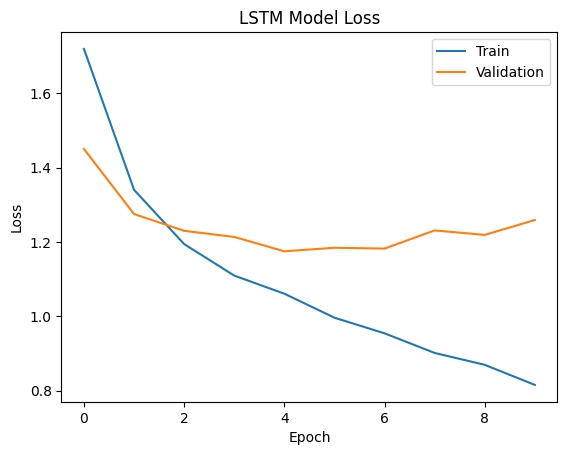

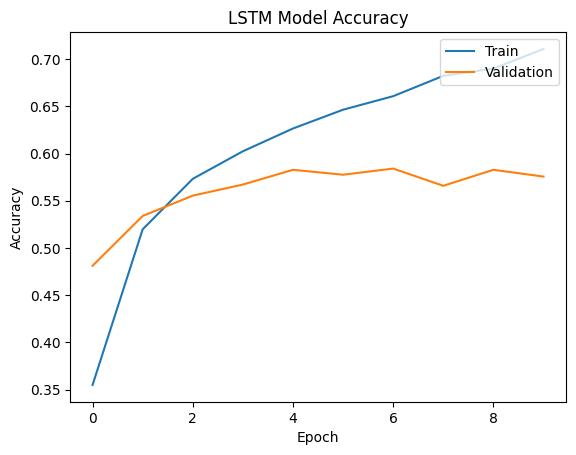

48/48 [==============================] - 1s 11ms/step
     Actual Value Predicted Value
0         sadness         sadness
1            fear            fear
2             joy             joy
3           shame         sadness
4            fear            fear
...           ...             ...
1529      disgust         disgust
1530          joy             joy
1531        guilt           shame
1532        anger           anger
1533        shame           guilt

[1534 rows x 2 columns]
Accuracy: 0.576%
Recall Score: 0.576
Precision: 0.575
F1 Score: 0.570


In [52]:
test_model("LSTM")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 400, 300)          2481900   
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 2,922,995
Trainable params: 441,095
Non-trainable params: 2,481,900
_________________________________________________________________
Epoch 1/10
48/48 [==============================] - 9s 129ms/step - loss: 1.7283 - accuracy: 0.3718 - val_loss: 1.4776 - val_accuracy: 0.4537
Epoch 2/10
48/48 [==============================] - 6s 120ms/step - loss: 1.3697 - accuracy: 0

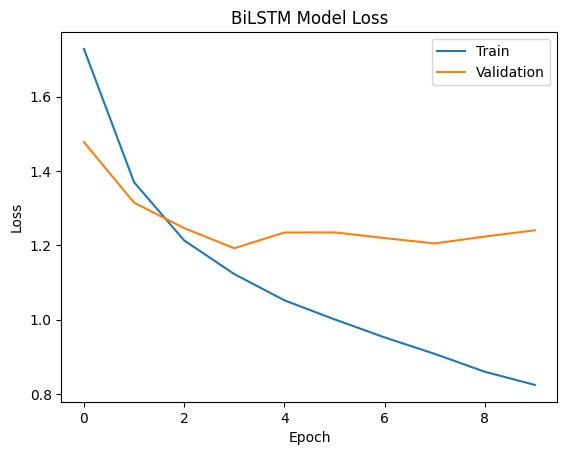

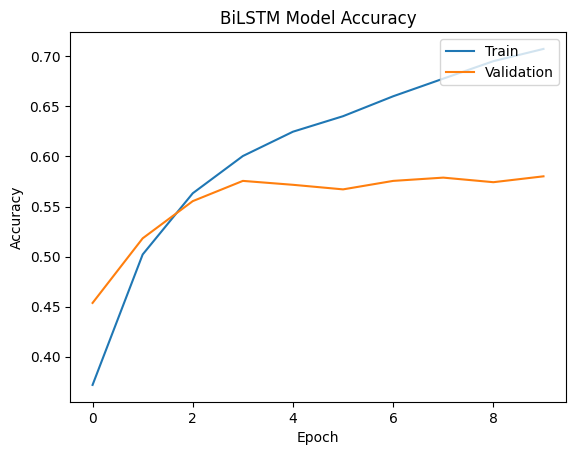

48/48 [==============================] - 2s 24ms/step
     Actual Value Predicted Value
0         sadness         sadness
1            fear            fear
2             joy             joy
3           shame           anger
4            fear            fear
...           ...             ...
1529      disgust         disgust
1530          joy             joy
1531        guilt           guilt
1532        anger           anger
1533        shame           guilt

[1534 rows x 2 columns]
Accuracy: 0.580%
Recall Score: 0.580
Precision: 0.581
F1 Score: 0.578


In [53]:
test_model("BiLSTM")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 400, 300)          2481900   
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              330240    
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 2,813,939
Trainable params: 332,039
Non-trainable params: 2,481,900
_________________________________________________________________
Epoch 1/10
48/48 [==============================] - 8s 121ms/step - loss: 1.7808 - accuracy: 0.3341 - val_loss: 1.5315 - val_accuracy: 0.4140
Epoch 2/10
48/48 [==============================] - 5s 102ms/step - loss: 1.3761 - accuracy: 

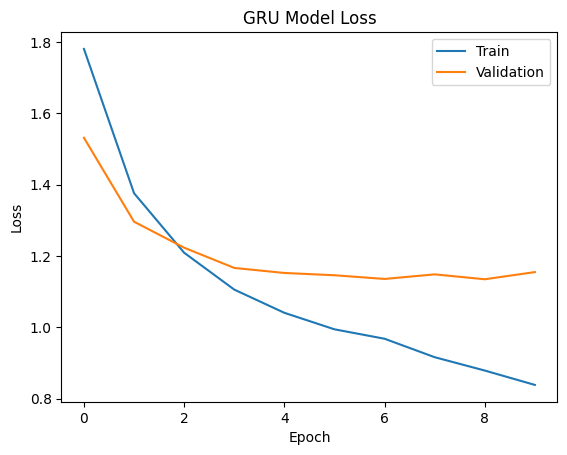

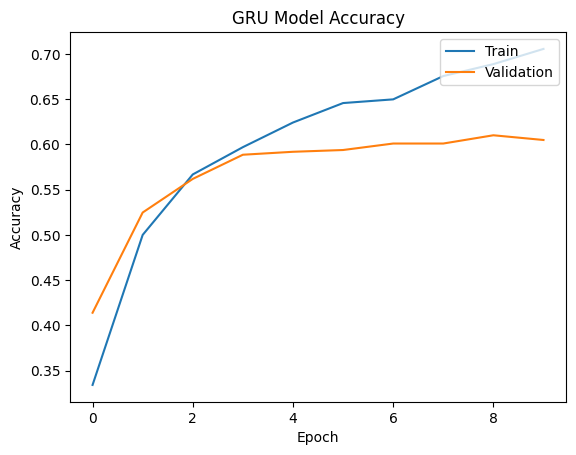

48/48 [==============================] - 1s 15ms/step
     Actual Value Predicted Value
0         sadness         sadness
1            fear            fear
2             joy             joy
3           shame           shame
4            fear            fear
...           ...             ...
1529      disgust         disgust
1530          joy             joy
1531        guilt           shame
1532        anger           anger
1533        shame           guilt

[1534 rows x 2 columns]
Accuracy: 0.605%
Recall Score: 0.605
Precision: 0.605
F1 Score: 0.603


In [54]:
test_model("GRU")